In [1]:
# data preprocessing
import pandas as pd
import numpy as np
import time
import os
import json
import copy
import shutil
from sklearn.model_selection import train_test_split

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# machine learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms

# augmentation
import albumentations 
from albumentations.pytorch.transforms import ToTensorV2

c:\Users\nicho\anaconda3\envs\EV2\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
train = pd.read_csv('../../datasets/data21k_kaggle/train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
with open('../../datasets/data21k_kaggle/label_num_to_disease_map.json') as f:
   mapping = json.loads(f.read())
   mapping = {int(k): v for k, v in mapping.items()}
mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [6]:
train['label_names'] = train['label'].map(mapping)
train.head()

,image_id,label,label_names
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


In [9]:
def plot_images(class_id, label, total_images=6):
    
    plot_list = train[train['label']==class_id].sample(total_images)['image_id'].tolist()
    labels = [label for _ in range(total_images)]

    size = int(np.sqrt(total_images))
    if size * size < total_images:
        size += 1

    plt.figure(figsize=(20,20))

    for index, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, index+1)
        image = Image.open(str('../../datasets/data21k_kaggle/train_images/'+image_id))
        plt.imshow(image)
        plt.title(label, fontsize=14)
        plt.axis('off')

plt.show()

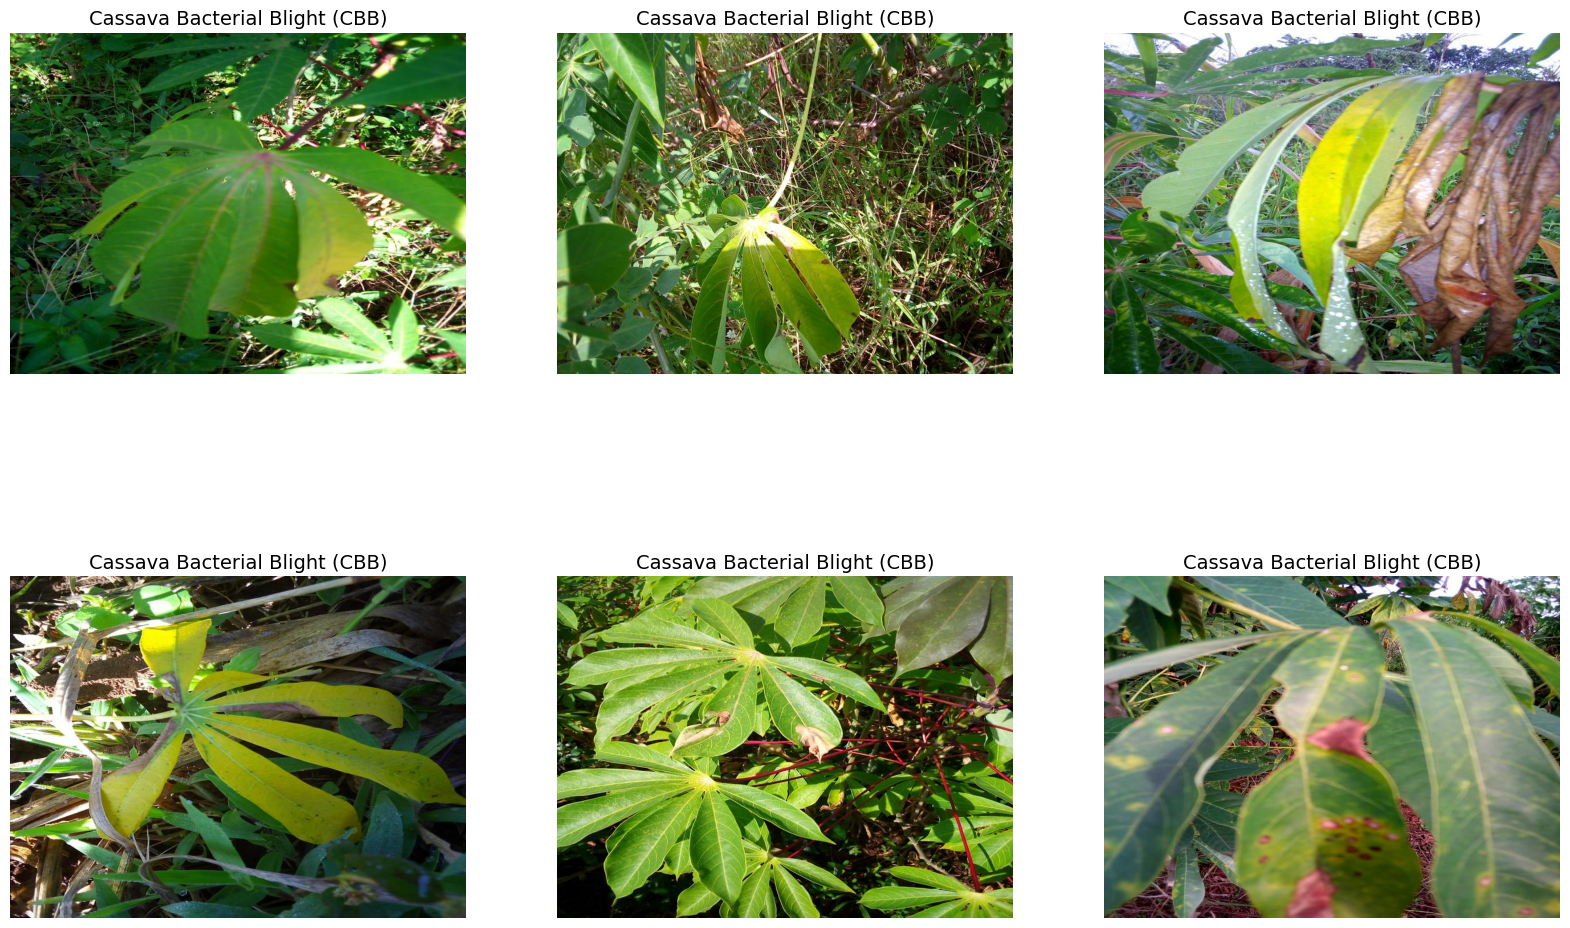

In [10]:
plot_images(0, mapping[0], 6)

<Axes: xlabel='count', ylabel='label_names'>

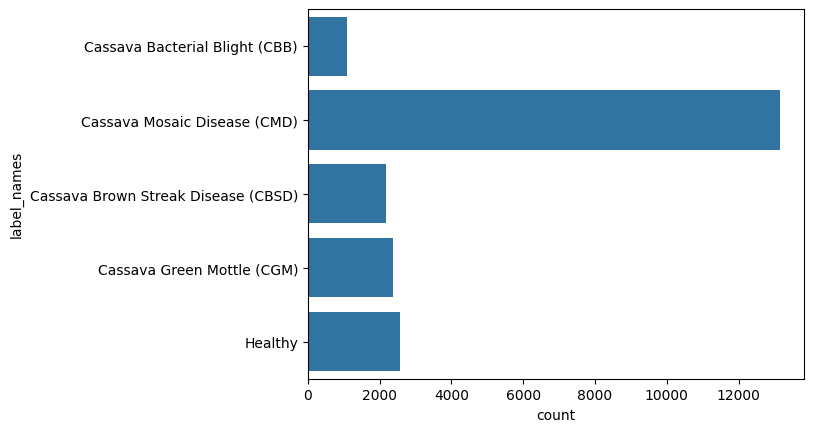

In [11]:
sns.countplot(train['label_names'])

In [12]:
DIM = (300, 300)
WIDTH, HEIGHT = DIM
NUM_CLASSES = 5
NUM_WORKERS = 16
TRAIN_BATCH_SIZE = 128
TRAIN_BATCH_SIZE = 128
SEED = 1
DEVICE = 'cuda'

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [13]:
def get_test_transforms(value = 'val'): 
   if value == 'train': 
      return albumentations.Compose([
         albumentations.Resize(WIDTH, HEIGHT),
         albumentations.HorizontalFlip(p=0.5),
         albumentations.Rotate(limit=(-90, 90)),
         albumentations.VerticalFlip(p=0.5),
         albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
         ToTensorV2(p=1.0),
      ])
   elif value == 'val':
      return albumentations.Compose([
         albumentations.Resize(WIDTH, HEIGHT),
         albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
         ToTensorV2(p=1.0),
      ])

In [20]:
class CassavaDataset(Dataset):
   def __init__(self, image_ids, labels, dimension=None, augmentations=None, folder='train_images'):
      super().__init__()
      self.image_ids = image_ids
      self.labels = labels
      self.dim = dimension
      self.augmentations = augmentations
      self.folder = folder

   def __len__(self): 
      return len(self.image_ids)
   
   def __getitem__(self, idx): 
      img = Image.open(os.path.join('../../datasets/data21k_kaggle', self.folder, self.image_ids[idx]))

      if self.dim: 
         img = img.resize(self.dim)

      img = np.array(img)

      if self.augmentations:
         augmented = self.augmentations(image=img)
         img = augmented['image']

      label = torch.tensor(self.labels[idx], dtype=torch.long)

      return img, label

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train['image_id'], train['label'], test_size=0.25)

In [22]:
from torch.utils.data import WeightedRandomSampler
def sampler_(labels):
    label_unique, counts = np.unique(labels, return_counts=True)
    print('Unique Labels', label_unique)
    weights = [sum(counts) / c for c in counts]
    sample_weights = [weights[w] for w in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

In [23]:
train_sampler = sampler_(y_train)

Unique Labels [0 1 2 3 4]


In [24]:
train_dataset = CassavaDataset(
   image_ids=x_train.values,
   labels=y_train.values,
   augmentations=get_test_transforms('train'),
   dimension=DIM
)

train_loader = DataLoader(
   train_dataset,
   batch_size=TRAIN_BATCH_SIZE,
   num_workers=NUM_WORKERS,
   shuffle=False
)

val_dataset = CassavaDataset(
   image_ids=x_test.values,
   labels=y_test.values,
   augmentations=get_test_transforms('val'),
   dimension=DIM
)

val_loader = DataLoader(
   val_dataset,
   batch_size=TRAIN_BATCH_SIZE,
   num_workers=NUM_WORKERS,
   shuffle=False
)

loaders = {'train': train_loader, 'val': val_loader}

In [25]:
train_dataset[0]

(tensor([[[ 1.3070,  1.1187,  0.8447,  ...,  1.7009,  2.0092,  1.9749],
          [ 0.9303,  0.8447,  0.5022,  ...,  1.4954,  1.9749,  2.0434],
          [ 0.6049,  0.7077,  0.7591,  ...,  0.8447,  1.5639,  1.9920],
          ...,
          [-0.9192, -0.8849, -0.7479,  ...,  0.4679,  0.9988,  1.7694],
          [-0.7650, -0.7137, -0.6281,  ...,  0.6734,  0.2624,  0.7933],
          [-0.3883, -0.3541, -0.2856,  ..., -0.1486,  0.5364,  0.3309]],
 
         [[ 1.6933,  1.5007,  1.3431,  ...,  1.7458,  2.0259,  2.0959],
          [ 1.4132,  1.2731,  0.9405,  ...,  1.5882,  1.9734,  2.1835],
          [ 1.1681,  1.1856,  1.2206,  ...,  1.1681,  1.7283,  2.1660],
          ...,
          [-0.2500, -0.2150, -0.1099,  ...,  1.0980,  1.5357,  2.1485],
          [-0.1800, -0.1275, -0.0049,  ...,  1.0980,  0.7829,  1.3081],
          [ 0.0826,  0.1352,  0.2052,  ...,  0.0476,  0.7479,  0.7129]],
 
         [[-0.2881, -0.8807, -0.8633,  ...,  0.9145,  0.8099,  0.5834],
          [-0.4798, -0.6890,

In [26]:
val_dataset[0]

(tensor([[[-1.3302, -1.2445, -1.2274,  ..., -0.6794, -0.6452, -0.8164],
          [-1.3473, -1.3473, -1.2959,  ..., -0.4911, -0.6452, -0.6623],
          [-1.5870, -1.6042, -1.5528,  ..., -0.2513, -0.5767, -0.5596],
          ...,
          [-1.4158, -1.0390,  0.3994,  ..., -1.2103, -1.1760, -1.7240],
          [-1.4158, -0.2856,  0.4508,  ..., -0.5938, -0.8507, -1.4843],
          [-1.4843, -1.0390, -0.5424,  ..., -0.8164, -0.8678, -1.3815]],
 
         [[-1.2654, -1.2829, -1.3354,  ..., -0.1275,  0.1527,  0.0651],
          [-1.3179, -1.3704, -1.3529,  ...,  0.0301,  0.1001,  0.2052],
          [-1.6155, -1.6506, -1.5105,  ...,  0.1352,  0.0826,  0.2752],
          ...,
          [-1.6506, -1.3880, -0.0924,  ..., -1.1253, -1.1604, -1.7731],
          [-1.6506, -0.6352, -0.0399,  ..., -0.7227, -1.0378, -1.7031],
          [-1.7206, -1.4230, -1.0378,  ..., -1.0203, -1.0903, -1.5980]],
 
         [[-0.7761, -0.4973, -0.4275,  ..., -0.5495, -0.2532, -0.0964],
          [-0.8110, -0.6715,

# transfer learning

In [27]:
def getModel():
    net = models.efficientnet_v2_m(pretrained=True)  # Load pre-trained model

    # Freeze all the layers
    for param in net.parameters():
        param.requires_grad = False

    # Get the number of input features for the classifier
    num_ftrs = net.classifier[1].in_features

    net.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, NUM_CLASSES),
        nn.LogSoftmax(dim=1)
    )

    # Move to GPU if available
    net = net.cuda() if DEVICE else net
    return net

In [28]:
model = getModel()

c:\Users\nicho\anaconda3\envs\EV2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicho\anaconda3\envs\EV2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
import math
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [30]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=1., momentum=0.9)
step_size = 4*len(train_loader)
clr = cyclical_lr(step_size, min_lr=3e-4, max_lr=3e-3)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [31]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [32]:
# freeze (or) unfreeze all the layers
unfreeze = True # to freeze, set it as False
for param in model.parameters():
    param.requires_grad = unfreeze

In [33]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{trainable_params:,} training parameters.')

53,187,577 total parameters.
53,187,577 training parameters.


In [34]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5, scheduler=scheduler):
   start_time = time.time()
   val_acc_history = []
   best_model_wts = copy.deepcopy(model.state_dict())
   best_acc = 0.0

   for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs-1}')
      print('-'*15)

      for phase in ['train', 'val']:
         if phase == 'train':
            model.train()
         else:
            model.eval()
         
         running_loss = 0.0
         running_corects = 0
         fin_out = []

         for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase=='train'):
               outputs = model(inputs)
               loss = criterion(outputs, labels)

               _, preds = torch.max(outputs, 1)

               if phase == 'train':
                  loss.backward()
                  optimizer.step()
                  scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corects += torch.sum(preds == labels.data)

         epoch_loss = running_loss / len(dataloaders[phase].dataset)
         epoch_acc = running_corects.double() / len(dataloaders[phase].dataset)

         print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

         if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
         if phase == 'val':
            val_acc_history.append(epoch_acc)

      print()
   
   end_time = time.time() - start_time

   print('Training completes in {:.0f}m {:.0f}s'.format(end_time // 60, end_time % 60))
   print('Best Val Acc: {:.4f}'.format(best_acc))

   model.load_state_dict(best_model_wts)
   return model, val_acc_history

In [ ]:
# train the model
model, accuracy = train_model(model=model, dataloaders=loaders, criterion=criterion, optimizer=optimizer, num_epochs=5, scheduler=scheduler)

Epoch 0/4
---------------


In [ ]:
torch.save(model, 'best_model.h5')
torch.save(model.state_dict(), 'best_model_weights.h5')

In [ ]:
unfreeze = True
for param in model.parameters():
   param.requires_grad = unfreeze

In [ ]:
layers = list(range(4, 7))
i = 0
for layer in model.children():
   if i in layers: 
      for param in layer.parameters():
         param.requires_grad = True
   i += 1

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def predict(model, dataloader, device):
    # set mode to eval
    model.eval()
    fin_out = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            
            fin_out.append(F.softmax(outputs, dim=1).detach().cpu().numpy())
            
    return np.concatenate(fin_out)

In [ ]:
device = torch.device('cuda') # if you don't have gpu, set it as cpu
model.to(device)
pred = predict(model, val_loader, device)
pred = pred.argmax(axis=1)

In [ ]:
y_test.values[:5]

In [ ]:
pred[:5]